# XGBoost with Prophet for interpolation and SHAP and LIME for XAI

XGBoost is a popular and efficient open-source implementation of the gradient boosted trees algorithm. Gradient boosting is a supervised learning algorithm, which attempts to accurately predict a target variable by combining the estimates of a set of simpler, weaker models.

Prophet is a procedure for forecasting time series data based on an additive model where non-linear trends are fit with yearly, weekly, and daily seasonality, plus holiday effects. It works best with time series that have strong seasonal effects and several seasons of historical data.

Explainable AI, or Interpretable AI, or Explainable Machine Learning, is artificial intelligence in which humans can understand the decisions or predictions made by the AI. It contrasts with the "black box" concept in machine learning where even its designers cannot explain why an AI arrived at a specific decision.

LIME stands for Local Interpretable Model-agnostic Explanations. It is a visualization technique that helps explain individual predictions. It is model agnostic so it can be applied to any supervised regression or classification model.

In [74]:
!pip install shap
!pip install interpret

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [158]:
## Included all necessary Header files
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import mean_absolute_error
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose

In [159]:
#Preprocessing the data
df = pd.read_excel("NizamabadPM.xlsx")
df.index = pd.to_datetime(df["Month"])
df.drop(columns="Month",inplace=True)

# EDA

            SQ2   NOx PM10 PM2.5 NH3   AQI
Month                                     
2016-01-01    -     -   67     -   -  62.0
2016-02-01    -     -   64     -   -  64.0
2016-03-01    -     -   66     -   -  66.0
2016-04-01    -     -   68     -   -  68.0
2016-05-01    -     -   71    43   -  69.0
...         ...   ...  ...   ...  ..   ...
2022-08-01  6.7  23.3   52    28  14  53.0
2022-09-01  7.9    25   51    31  16  54.0
2022-10-01  8.6  27.4   61    35  18  63.0
2022-11-01  6.8    25   56    30  16  56.0
2022-12-01  7.5  22.6   60    29  17  59.0

[84 rows x 6 columns]


<AxesSubplot:xlabel='Month'>

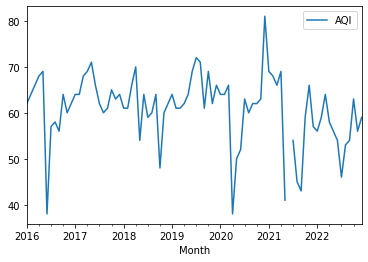

In [160]:
print(df)
df.plot()

In [161]:
print(df.dtypes)
print(df.isna().sum())

SQ2       object
NOx       object
PM10      object
PM2.5     object
NH3       object
AQI      float64
dtype: object
SQ2       1
NOx       4
PM10      1
PM2.5    11
NH3      25
AQI       1
dtype: int64


<AxesSubplot:xlabel='Month'>

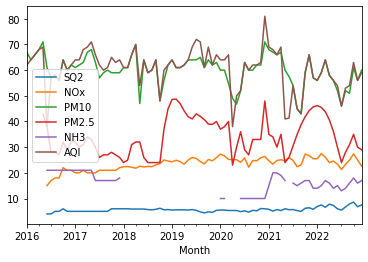

In [166]:
df["PM2.5"] = pd.to_numeric(df["PM2.5"],errors='coerce')
df["PM2.5"] = df["PM2.5"].interpolate(method="spline",order=3)
df["SQ2"] = pd.to_numeric(df["SQ2"],errors='coerce')
df["SQ2"] = df["SQ2"].interpolate(method="spline",order=3)
df["NOx"] = pd.to_numeric(df["NOx"],errors='coerce')
df["NOx"] = df["NOx"].interpolate(method="spline",order=3)
df["PM10"] = pd.to_numeric(df["PM10"],errors='coerce')
df["PM10"] = df["PM10"].interpolate(method="spline",order=3)
df["NH3"] = df["NH3"].interpolate(method="spline",order=3)
df["NH3"] = pd.to_numeric(df["NH3"],errors='coerce')
df["AQI"] = df["AQI"].interpolate(method="spline",order=3)
df["AQI"] = pd.to_numeric(df["AQI"],errors='coerce')
df.plot()

In [167]:
df.drop(columns="PM2.5",inplace=True)

In [168]:
df

,SQ2,NOx,PM10,NH3,AQI
Month,,,,,
2016-01-01,NaN,NaN,67.0,NaN,62.0
2016-02-01,NaN,NaN,64.0,NaN,64.0
2016-03-01,NaN,NaN,66.0,NaN,66.0
2016-04-01,NaN,NaN,68.0,NaN,68.0
2016-05-01,NaN,NaN,71.0,NaN,69.0
...,...,...,...,...,...
2022-08-01,6.7,23.3,52.0,14.0,53.0
2022-09-01,7.9,25.0,51.0,16.0,54.0
2022-10-01,8.6,27.4,61.0,18.0,63.0


# XGBoost Model

In [169]:
df.dtypes

SQ2     float64
NOx     float64
PM10    float64
NH3     float64
AQI     float64
dtype: object

In [170]:
import xgboost as xgb
import shap

# Split the data into training and testing sets
X = df.drop(['AQI'], axis=1)
y = df['AQI']
X_train = X.head(72)
X_test = X.tail(12)
y_train = y.head(72)
y_test = y.tail(12)

# Define the XGBoost model parameters
params = {
    'objective': 'reg:squarederror',
    'colsample_bytree': 0.3,
    'learning_rate': 0.1,
    'max_depth': 5,
    'alpha': 10,
    'n_estimators': 100
}

# Train the XGBoost model
model = xgb.XGBRegressor(**params)
model.fit(X_train, y_train)

# Generate predictions for the test set
y_pred = model.predict(X_test)

# Error Calculation

In [171]:
# Calculate the mean squared error (MSE) of the predictions
from sklearn.metrics import mean_squared_error,mean_absolute_error,mean_absolute_percentage_error
from math import sqrt
rmse = round(sqrt(mean_squared_error(y_test, y_pred)),2)
mae = round(mean_absolute_error(y_test, y_pred),2)
mape = mean_absolute_percentage_error(y_test, y_pred)

print(f"RMSE : {rmse}")
print(f"MAE  : {mae}")
print(f"MAPE : {mape*100}%")

RMSE : 3.47
MAE  : 2.79
MAPE : 5.171212430630144%


# SHAP

SHAP stands for SHapley Additive exPlanations. Shap is an explainable AI framework derived from the shapley values of the game theory. This algorithm was first published in 2017 by Lundberg and Lee. Shapley value can be defined as the average marginal contribution of a feature value over all possible coalitions.

/usr/local/lib/python3.8/dist-packages/xgboost/core.py:122: UserWarning:

ntree_limit is deprecated, use `iteration_range` or model slicing instead.



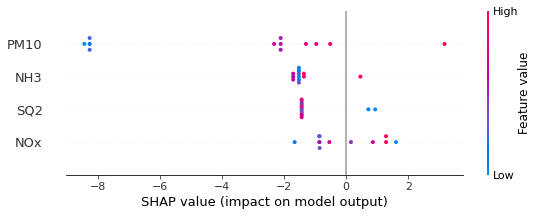

In [172]:
# Generate SHAP values for the test set
explainer = shap.Explainer(model)
shap_values = explainer(X_test)

# Plot the SHAP summary plot
shap.summary_plot(shap_values, X_test)

/usr/local/lib/python3.8/dist-packages/xgboost/core.py:122: UserWarning:

ntree_limit is deprecated, use `iteration_range` or model slicing instead.



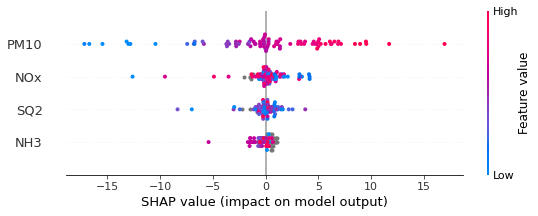

In [173]:
import shap

# Load the data
data = shap.datasets.diabetes()

# Train the XGBoost model
# Split the data into training and testing sets
X = df.drop(['AQI'], axis=1)
y = df['AQI']
model = xgb.XGBRegressor()
model.fit(X, y)

# Generate SHAP values for the dataset
explainer = shap.Explainer(model)
shap_values = explainer(X)

shap.summary_plot(shap_values, X)
# Create the SHAP dependence plot for the most important feature
#shap.dependence_plot('PM10', shap_values, X, show=False)



In [174]:
from interpret.blackbox import LimeTabular
from interpret import show
lime = LimeTabular(predict_fn=model.predict,data=X_train,random_state=1)
# Get local explanations
lime_local = lime.explain_local(X_test[-12:],y_test[-12:],name='LIME')

show(lime_local)

ERROR:interpret.utils.all:Missing values are currently not supported.


ValueError: ignored

In [188]:
shap.initjs()
# Generate SHAP values for a single prediction
explainer = shap.Explainer(model)
shap_values = explainer(X[:1])

# Create the SHAP force plot for the first prediction
shap.plots.force(shap_values[0])

/usr/local/lib/python3.8/dist-packages/xgboost/core.py:122: UserWarning:

ntree_limit is deprecated, use `iteration_range` or model slicing instead.



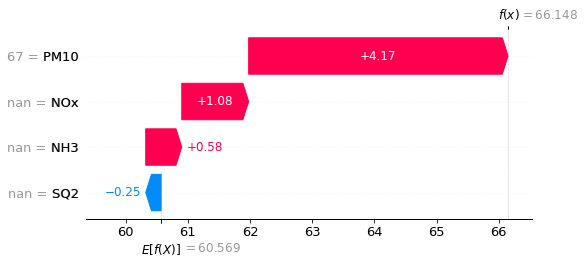

In [189]:
# Generate SHAP values for the entire dataset
explainer = shap.Explainer(model)
shap_values = explainer(X)

# Create the SHAP waterfall plot for the dataset
shap.plots.waterfall(shap_values[0])

# Prophet

In [175]:
!pip install pystan~=2.14
!pip install fbprophet

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [176]:
from pandas.tseries.offsets import DateOffset
pred_date=[df.index[-1]+ DateOffset(months=x)for x in range(1,13)]
pred_date=pd.DataFrame(index=pred_date,columns=df.columns)
data = pd.concat([df,pred_date])

In [177]:
data

,SQ2,NOx,PM10,NH3,AQI
2016-01-01,NaN,NaN,67.0,NaN,62.0
2016-02-01,NaN,NaN,64.0,NaN,64.0
2016-03-01,NaN,NaN,66.0,NaN,66.0
2016-04-01,NaN,NaN,68.0,NaN,68.0
2016-05-01,NaN,NaN,71.0,NaN,69.0
...,...,...,...,...,...
2023-08-01,NaN,NaN,NaN,NaN,NaN
2023-09-01,NaN,NaN,NaN,NaN,NaN
2023-10-01,NaN,NaN,NaN,NaN,NaN
2023-11-01,NaN,NaN,NaN,NaN,NaN


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


,SQ2,NOx,PM10,NH3,AQI
2016-01-01,NaN,NaN,67.000000,NaN,62.0
2016-02-01,NaN,NaN,64.000000,NaN,64.0
2016-03-01,NaN,NaN,66.000000,NaN,66.0
2016-04-01,NaN,NaN,68.000000,NaN,68.0
2016-05-01,NaN,NaN,71.000000,NaN,69.0
...,...,...,...,...,...
2023-08-01,NaN,NaN,57.758408,NaN,NaN
2023-09-01,NaN,NaN,57.495413,NaN,NaN
2023-10-01,NaN,NaN,51.208375,NaN,NaN
2023-11-01,NaN,NaN,55.982277,NaN,NaN


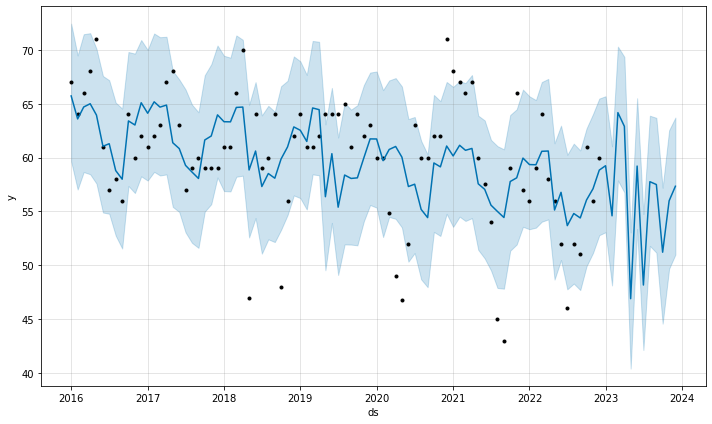

In [178]:
from fbprophet import Prophet
df1 = df[["PM10"]]
df1=df1.reset_index()
df1.rename(columns={'Month': 'ds', 'PM10': 'y'}, inplace=True)
df1["y"] = df1["y"].interpolate(method="linear")
model = Prophet(seasonality_mode="multiplicative")
model.fit(df1)
future_dates=model.make_future_dataframe(periods=12,freq='M')
prediction = model.predict(future_dates)
model.plot(prediction)
data["PM10"][-12:]=prediction["yhat"][-12:]
data

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


,SQ2,NOx,PM10,NH3,AQI
2016-01-01,NaN,NaN,67.000000,NaN,62.0
2016-02-01,NaN,NaN,64.000000,NaN,64.0
2016-03-01,NaN,NaN,66.000000,NaN,66.0
2016-04-01,NaN,NaN,68.000000,NaN,68.0
2016-05-01,NaN,NaN,71.000000,NaN,69.0
...,...,...,...,...,...
2023-08-01,7.059481,26.111234,57.758408,14.989660,NaN
2023-09-01,7.562282,23.758079,57.495413,16.854275,NaN
2023-10-01,8.679231,25.080079,51.208375,20.935336,NaN
2023-11-01,6.128997,23.386159,55.982277,18.913097,NaN


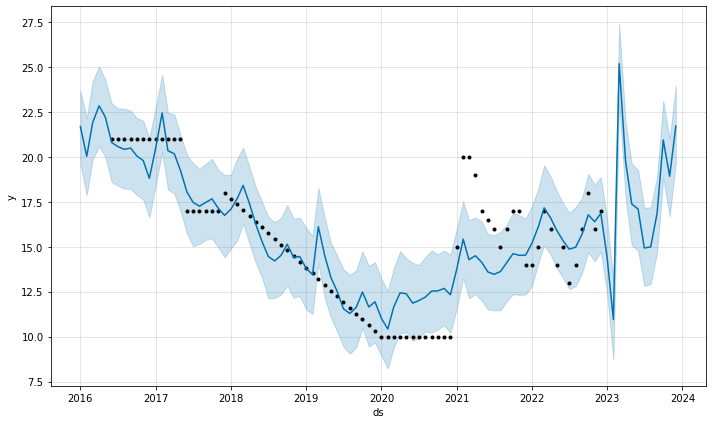

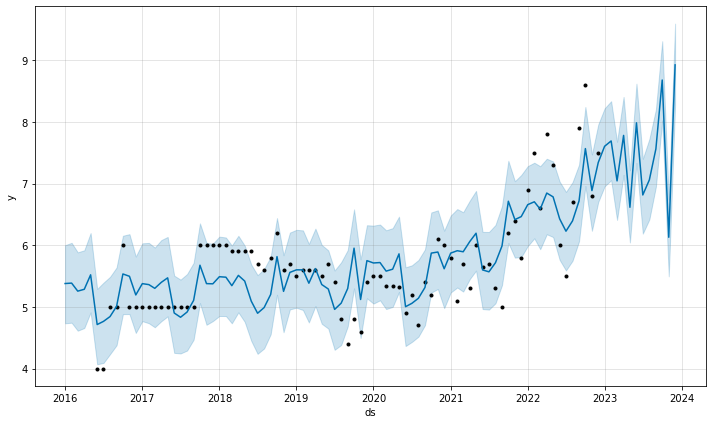

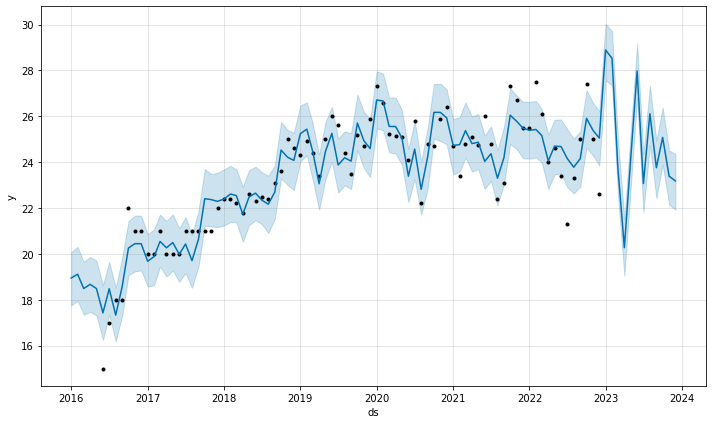

In [179]:
df1 = df[["NH3"]]
df1=df1.reset_index()
df1.rename(columns={'Month': 'ds', 'NH3': 'y'}, inplace=True)
df1["y"] = df1["y"].interpolate(method="linear")
model = Prophet(seasonality_mode="multiplicative")
model.fit(df1)
future_dates=model.make_future_dataframe(periods=12,freq='M')
prediction = model.predict(future_dates)
model.plot(prediction)
data["NH3"][-12:]=prediction["yhat"][-12:]


df1 = df[["SQ2"]]
df1=df1.reset_index()
df1.rename(columns={'Month': 'ds', 'SQ2': 'y'}, inplace=True)
df1["y"] = df1["y"].interpolate(method="linear")
model = Prophet(seasonality_mode="multiplicative")
model.fit(df1)
future_dates=model.make_future_dataframe(periods=12,freq='M')
prediction = model.predict(future_dates)
model.plot(prediction)
data["SQ2"][-12:]=prediction["yhat"][-12:]


df1 = df[["NOx"]]
df1=df1.reset_index()
df1.rename(columns={'Month': 'ds', 'NOx': 'y'}, inplace=True)
df1["y"] = df1["y"].interpolate(method="linear")
model = Prophet(seasonality_mode="multiplicative")
model.fit(df1)
future_dates=model.make_future_dataframe(periods=12,freq='M')
prediction = model.predict(future_dates)
model.plot(prediction)
data["NOx"][-12:]=prediction["yhat"][-12:]

data

In [180]:
len(data)
data

,SQ2,NOx,PM10,NH3,AQI
2016-01-01,NaN,NaN,67.000000,NaN,62.0
2016-02-01,NaN,NaN,64.000000,NaN,64.0
2016-03-01,NaN,NaN,66.000000,NaN,66.0
2016-04-01,NaN,NaN,68.000000,NaN,68.0
2016-05-01,NaN,NaN,71.000000,NaN,69.0
...,...,...,...,...,...
2023-08-01,7.059481,26.111234,57.758408,14.989660,NaN
2023-09-01,7.562282,23.758079,57.495413,16.854275,NaN
2023-10-01,8.679231,25.080079,51.208375,20.935336,NaN
2023-11-01,6.128997,23.386159,55.982277,18.913097,NaN


In [181]:
data['PM10'] = pd.to_numeric(data['PM10'],errors='coerce')
data['NH3'] = pd.to_numeric(data['NH3'],errors='coerce')
data['AQI'] = pd.to_numeric(data['AQI'],errors='coerce')
data.dtypes

SQ2     float64
NOx     float64
PM10    float64
NH3     float64
AQI     float64
dtype: object

/usr/local/lib/python3.8/dist-packages/xgboost/core.py:122: UserWarning:

ntree_limit is deprecated, use `iteration_range` or model slicing instead.



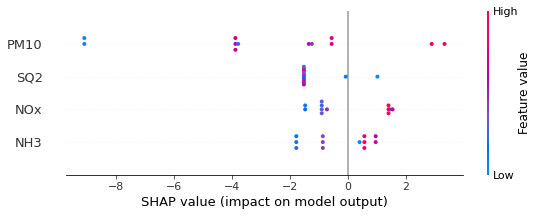

In [182]:
import xgboost as xgb
import shap

# Split the data into training and testing sets
X = data.drop(['AQI'], axis=1)
y = data['AQI']
X_train = X.head(84)
X_test = X.tail(12)
y_train = y.head(84)
y_test = y.tail(12)

# Define the XGBoost model parameters
params = {
    'objective': 'reg:squarederror',
    'colsample_bytree': 0.3,
    'learning_rate': 0.1,
    'max_depth': 5,
    'alpha': 10,
    'n_estimators': 100
}

# Train the XGBoost model
model = xgb.XGBRegressor(**params)
model.fit(X_train, y_train)

# Generate predictions for the test set
y_pred = model.predict(X_test)

# Generate SHAP values for the test set
explainer = shap.Explainer(model)
shap_values = explainer(X_test)

# Plot the SHAP summary plot
shap.summary_plot(shap_values, X_test)




In [183]:
y_pred

array([58.11637 , 59.616737, 62.05474 , 64.365974, 49.63994 , 59.031044,
       46.712704, 54.937733, 53.40927 , 55.11505 , 60.296364, 54.271946],
      dtype=float32)

In [184]:
data[["AQI"]]

,AQI
2016-01-01,62.0
2016-02-01,64.0
2016-03-01,66.0
2016-04-01,68.0
2016-05-01,69.0
...,...
2023-08-01,NaN
2023-09-01,NaN
2023-10-01,NaN
2023-11-01,NaN


In [185]:
data_final = data[["AQI"]]
data_final["AQI"][-12:] = y_pred

/usr/local/lib/python3.8/dist-packages/pandas/core/series.py:1105: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-185-0736fbe3cf5c>:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [186]:
data_final.to_csv("Khammam_AQI_XGB.csv")

<AxesSubplot:>

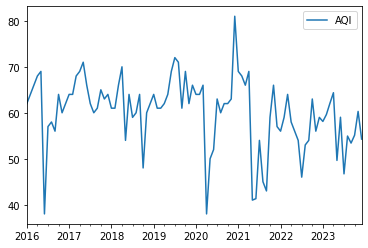

In [187]:
data_final.plot()